In [2]:
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torchvision import transforms
from PIL import Image
import gzip
%matplotlib inline

In [3]:
# 加载数据
def load_data(data_file):
    files = ['train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz']
    paths = []
    for fileName in files:
        paths.append(os.path.join(data_file, fileName))
        
    # 读取每个文件夹的数据    
    with gzip.open(paths[0], 'rb') as train_labels_path:   # rb 以2进制格式打开
        train_labels = np.frombuffer(train_labels_path.read(), np.uint8, offset=8)
      
    with gzip.open(paths[1], 'rb') as train_images_path:
        train_images = np.frombuffer(train_images_path.read(), np.uint8, offset=16).reshape(len(train_labels), 784)
       
    with gzip.open(paths[2], 'rb') as test_labels_path:
        test_labels = np.frombuffer(test_labels_path.read(), np.uint8, offset=8)
        
    with gzip.open(paths[3], 'rb') as test_images_path:
        test_images = np.frombuffer(test_images_path.read(), np.uint8, offset=16).reshape(len(test_labels), 784)
        
    return train_labels,train_images,test_labels,test_images
 
train_labels,train_images,test_labels,test_images = load_data('C:\\Users\\Fan\\JupyterFile\\data\\MNIST\\raw\\')
print(train_labels.shape)
print(train_images.shape)
print(test_labels.shape)
print(test_images.shape)

(60000,)
(60000, 784)
(10000,)
(10000, 784)


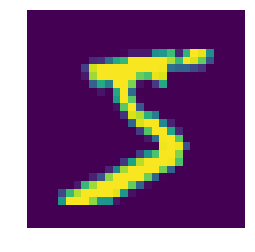

In [4]:
plt.imshow(train_images[0].reshape(28,28))
plt.axis('off')
plt.show()

In [5]:
# 创建加载器
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        image = self.images[idx].reshape(28,28)
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image,label
transform = transforms.Compose([
    transforms.ToTensor(),         # 转换为Tensor张量
])

batch_size = 64

train_dataset = ImageDataset(images = train_images, labels = train_labels, transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = ImageDataset(images = test_images, labels = test_labels, transform = transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [6]:
def show_image(tensor):
    tensor=torch.clamp(tensor,0,1)
    tensor = tensor.squeeze().numpy()
    plt.imshow(tensor)
    plt.axis('off')  # 关闭坐标轴
    plt.show()

In [7]:
# 模型定义
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)   # 输入层
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)           # ？
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)                   # 输出层

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))         # 第一层卷积        28->24
        x = nn.functional.max_pool2d(x, 2)            # 池化              24->12
        x = nn.functional.relu(self.conv2(x))         # 第二层卷积        12->8
        x = nn.functional.max_pool2d(x, 2)            # 池化              8->4
        x = x.view(-1, 16*4*4)                      # 将特征图展平
        x = nn.functional.relu(self.fc1(x))           # 全连接
        x = nn.functional.relu(self.fc2(x))           # 全连接
        x = self.fc3(x)                               # 输出
        return x
model=LeNet()

In [ ]:
# 训练模型
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss() # 交叉熵损失
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses=[]
num_epochs = 25
for epoch in range(num_epochs):
    model.train()   # 训练模式，打开参数更新
    running_loss = 0.0
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')
    losses.append(running_loss/len(train_loader))
plt.plot(losses)
plt.show()


E:\anaconda3\lib\site-packages\torchvision\transforms\functional.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:205.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Epoch [1/25], Loss: 0.31357184577800795


In [ ]:
# 模型测试
model.eval()   # 评价模式，禁止参数更新
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i,boll in enumerate(predicted == labels):
            if boll == False:    # 输出错误图片
                show_image(images[i])
                print('True:',int(labels[i]))
                print('Pre:',int(predicted[i]))
            
print(f'测试集正确率：{(correct / total) * 100:.2f}%')

In [12]:
criterion = nn.CrossEntropyLoss() # 交叉熵损失
for images, labels in train_loader:
    outputs = model(images)
    loss = criterion(outputs, labels)
    print(loss)
    print(outputs.shape)
    print(labels.shape)

tensor(2.3099, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3103, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3021, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2995, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2928, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2969, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3269, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3060, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3080, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2941, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2893, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3005, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3034, grad_fn=<NllL

tensor(2.2974, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3248, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3054, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2972, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3077, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3087, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3143, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3084, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3130, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3080, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3094, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3066, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3054, grad_fn=<NllL

tensor(2.2933, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3087, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2996, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2905, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2971, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3037, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3152, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3078, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2944, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2875, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3134, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2958, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3082, grad_fn=<NllL

tensor(2.2985, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3004, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3107, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3037, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3005, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3069, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3054, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3111, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3081, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3083, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3047, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2984, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2913, grad_fn=<NllL

tensor(2.3144, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3022, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2999, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3017, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3036, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3029, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3080, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2994, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3114, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3142, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3113, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3192, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3086, grad_fn=<NllL

tensor(2.2999, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3103, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3040, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3039, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3073, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3016, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2966, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3064, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2918, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3063, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3091, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3053, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3033, grad_fn=<NllL

tensor(2.2938, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3082, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2887, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2959, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2944, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2963, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3177, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3209, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2910, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3178, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3060, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3024, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3085, grad_fn=<NllL

tensor(2.3015, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3134, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3084, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3031, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3098, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3027, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3157, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3168, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3125, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3020, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3059, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3165, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3086, grad_fn=<NllL

tensor(2.3210, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2992, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3112, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3074, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3087, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2997, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2987, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3133, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3090, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2887, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3135, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2988, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3072, grad_fn=<NllL

tensor(2.3080, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2996, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2956, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2810, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3147, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3098, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3124, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2972, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2995, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.2995, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3136, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3114, grad_fn=<NllLossBackward0>)
torch.Size([64, 10])
torch.Size([64])
tensor(2.3106, grad_fn=<NllL

In [13]:
labels

tensor([7, 1, 0, 3, 4, 6, 8, 4, 9, 0, 0, 3, 5, 6, 8, 6, 4, 4, 1, 5, 9, 1, 0, 7,
        3, 7, 8, 8, 0, 8, 1, 9], dtype=torch.uint8)

In [24]:
outputs

tensor([[ 0.1057, -0.0713,  0.0562, -0.0549, -0.0207, -0.0174, -0.0889,  0.1143,
         -0.0165, -0.0959],
        [ 0.1052, -0.0694,  0.0666, -0.0536, -0.0183, -0.0266, -0.0921,  0.1060,
         -0.0321, -0.0817],
        [ 0.1223, -0.0758,  0.0601, -0.0639, -0.0268, -0.0279, -0.0897,  0.1112,
         -0.0139, -0.0813],
        [ 0.1142, -0.0618,  0.0574, -0.0647, -0.0213, -0.0303, -0.0911,  0.1165,
         -0.0138, -0.0706],
        [ 0.1187, -0.0711,  0.0656, -0.0556, -0.0147, -0.0346, -0.0928,  0.1167,
         -0.0313, -0.0789],
        [ 0.1152, -0.0729,  0.0488, -0.0652, -0.0200, -0.0420, -0.0879,  0.1159,
         -0.0117, -0.0850],
        [ 0.1096, -0.0618,  0.0592, -0.0550, -0.0156, -0.0190, -0.0895,  0.1185,
         -0.0275, -0.0842],
        [ 0.1146, -0.0669,  0.0578, -0.0565, -0.0271, -0.0273, -0.0951,  0.1201,
         -0.0222, -0.0818],
        [ 0.1054, -0.0653,  0.0605, -0.0534, -0.0182, -0.0286, -0.0943,  0.1163,
         -0.0173, -0.0877],
        [ 0.1296, -